In [ ]:
# https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
#https://www.kaggle.com/datasets/chetankv/dogs-cats-images

# IMPORT BIBLIOTEK
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# IMPORT MODELI ML 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# WCZYTANIE DANYCH
df = pd.read_csv("archive\AB_NYC_2019.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
# CZYSZCZENIE I EKSPLORACJA DANYCH
# Rozmiar danych
df.shape

# Informacje o typach danych i brakach
df.info()

# Sprawdzenie braków
df.isnull().sum()

# Usunięcie niepotrzebnych kolumn
df = df.drop(columns=["id", "name", "host_id", "host_name", "last_review"])

# Wypełnienie braków w reviews_per_month zerem
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [8]:
# TRENOWANIE MODELI

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline z RandomForest
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Pipeline z regresją liniową
lr_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)


In [ ]:
# OCENA MODELI
def print_metrics(y_test, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("R2 Score:", r2_score(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print()

print_metrics(y_test, y_pred_rf, "Random Forest")
print_metrics(y_test, y_pred_lr, "Linear Regression")

#greed search
#porownanie test vs train 
#dok ze wskazowkkami
# medical images 


--- Random Forest ---
R2 Score: 0.5270949286354789
RMSE: 58.18602688520127

--- Linear Regression ---
R2 Score: 0.46171761874073713
RMSE: 62.077868999044895



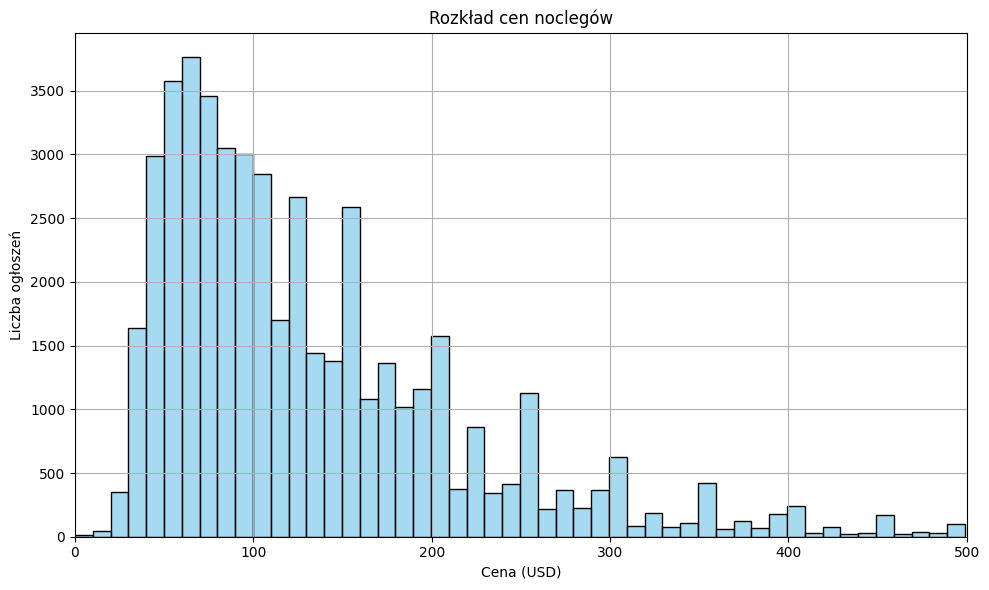

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram z ustalonymi przedziałami (bins)
plt.figure(figsize=(10, 6))
sns.histplot(df["price"], bins=50, kde=False, color='skyblue', edgecolor='black')

plt.title("Rozkład cen noclegów")
plt.xlabel("Cena (USD)")
plt.ylabel("Liczba ogłoszeń")
plt.xlim(0, 500)  # Obcięcie outlierów
plt.grid(True)
plt.tight_layout()
plt.show()

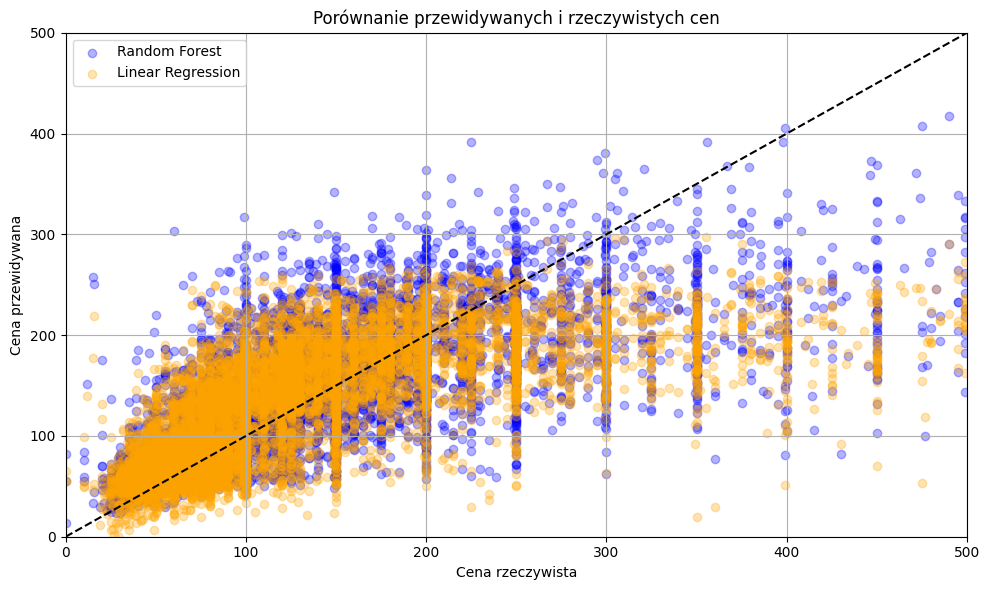

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, label="Random Forest", color='blue')
plt.scatter(y_test, y_pred_lr, alpha=0.3, label="Linear Regression", color='orange')

plt.plot([0, 500], [0, 500], '--k')  # linia 
plt.xlim(0, 500)
plt.ylim(0, 500)

plt.xlabel("Cena rzeczywista")
plt.ylabel("Cena przewidywana")
plt.title("Porównanie przewidywanych i rzeczywistych cen")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\vdi-terminal\AppData\Local\Temp\ipykernel_10896\420609630.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="neighbourhood_group", y="price", data=df[df["price"] < 500], ci=None, palette="viridis")
C:\Users\vdi-terminal\AppData\Local\Temp\ipykernel_10896\420609630.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="neighbourhood_group", y="price", data=df[df["price"] < 500], ci=None, palette="viridis")


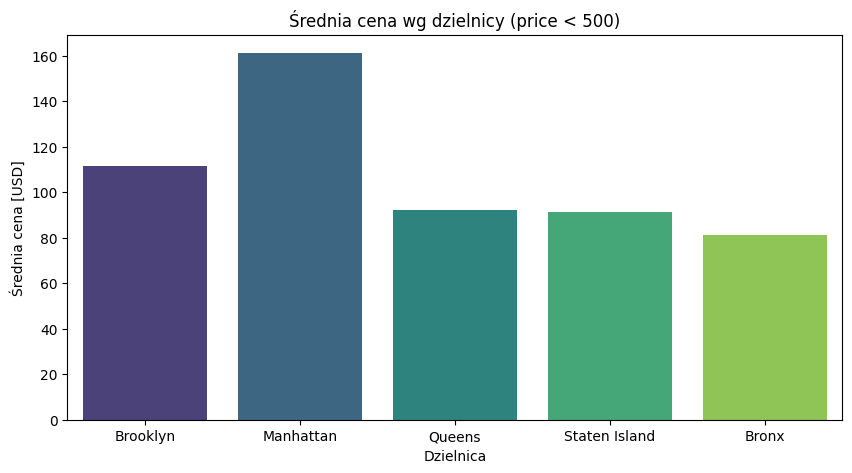

In [13]:
plt.figure(figsize=(10, 5))
sns.barplot(x="neighbourhood_group", y="price", data=df[df["price"] < 500], ci=None, palette="viridis")
plt.title("Średnia cena wg dzielnicy (price < 500)")
plt.xlabel("Dzielnica")
plt.ylabel("Średnia cena [USD]")
plt.show()

In [ ]:
!pip install folium
import folium
from folium.plugins import MarkerCluster

# Filtrowanie (tylko oferty < $300)
filtered_df = df[df["price"] < 300].sample(1000, random_state=42)  # losowe 1000, bo mapa będzie lżejsza

# tworzenie mapy
mapa = folium.Map(location=[40.7128, -74.0060], zoom_start=11)  # NYC

# Dodanie klastrów
marker_cluster = MarkerCluster().add_to(mapa)

# Dodanie punktów
for _, row in filtered_df.iterrows():
    popup_text = f"{row['neighbourhood']} ({row['room_type']})<br>Cena: ${row['price']}"
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=popup_text,
        icon=folium.Icon(color="blue", icon="home", prefix="fa")
    ).add_to(marker_cluster)

# Wyświetlenie
mapa


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
y_pred_reset = pd.Series(y_pred_rf, name="predicted_price_rf")

# Poloacznie dnaych
map_df = pd.concat([X_test_reset[["latitude", "longitude"]], y_test_reset, y_pred_reset], axis=1)

# błąd predykcji
map_df["error"] = map_df["predicted_price_rf"] - map_df["price"]


In [ ]:
import folium
from folium.plugins import MarkerCluster

# Próbkowanie danych do mapy 
sample_map_df = map_df.sample(500, random_state=42)

# Utwórz mapę
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
marker_cluster = MarkerCluster().add_to(m)

# Kolor punktu wg błędu
def get_color(error):
    if error > 50:
        return "red"
    elif error < -50:
        return "green"
    else:
        return "blue"

# Dodaj punkty
for _, row in sample_map_df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=4,
        color=get_color(row["error"]),
        fill=True,
        fill_color=get_color(row["error"]),
        fill_opacity=0.7,
        popup=f"Rzeczywista cena: ${row['price']}<br>Predykcja: ${row['predicted_price_rf']:.2f}<br>Błąd: ${row['error']:.2f}"
    ).add_to(marker_cluster)

# Pokaż mapę
m


In [23]:
# 1. Dane wejściowe od użytkownika 
input_data = {
    "neighbourhood_group": "Manhattan",
    "neighbourhood": "Harlem",
    "latitude": 40.80902,
    "longitude": -73.9419,
    "room_type": "Entire home/apt",
    "minimum_nights": 3,
    "number_of_reviews": 15,
    "reviews_per_month": 1.2,
    "calculated_host_listings_count": 2,
    "availability_365": 180
}

input_df = pd.DataFrame([input_data])
predicted_price = rf_model.predict(input_df)[0]

print(f"Sugerowana cena wynajmu: ${predicted_price:.2f} za noc")


Sugerowana cena wynajmu: $200.47 za noc
